This notebook illustrates the pipeline of the topological analysis of sharp-wave ripples (SWR). Given that some parts of the code are computationally expensive, we provide pre-computed results in a file. If you are interested in either testing your own data or check the computation of the provided dataset you can execute the corresponding part locally.

## **Install necessary modules**

In [ ]:
!pip install scikit-dimension
!pip install Cython
!pip install Ripser
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 74 kB 1.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 5.9 MB/s 
  Created wheel for Ripser: filename=ripser-0.6.4-cp38-cp38-linux_x86_64.whl size=458218 sha256=a69245eb7b5d2200a2f1a763ee4d8b885762025e1e6a6a5525fef58f837389d6
  Stored in directory: /root/.cache/pip/wheels/2a/91/ce/d7deed9ae6fb975821947c9aaa86134c95d2fe3f4b0f89b59e
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=63428aac54537018e0e3edf48c381cf8de2da0df

## **Download data**

You can skip this part if you are going to use your own data.

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=11RpUowIZOgblwqtthwhneBCdGyCmtjR-' -O 'barcodes.pickle'
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=171e9uBWMRbL5jxlrzY-lyrY_0v0-XiXR' -O 'ripple_data.pkl'

--2022-12-02 12:16:09--  https://drive.google.com/uc?export=download&id=11RpUowIZOgblwqtthwhneBCdGyCmtjR-
Resolving drive.google.com (drive.google.com)... 74.125.124.100, 74.125.124.139, 74.125.124.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.124.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r09hn5gqdv74rl67hu5ft8p2bjba7gif/1669983300000/03035122749300792974/*/11RpUowIZOgblwqtthwhneBCdGyCmtjR-?e=download&uuid=a4cf6f3d-95f7-440f-8177-e7e6cf101e80 [following]
--2022-12-02 12:16:10--  https://doc-04-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/r09hn5gqdv74rl67hu5ft8p2bjba7gif/1669983300000/03035122749300792974/*/11RpUowIZOgblwqtthwhneBCdGyCmtjR-?e=download&uuid=a4cf6f3d-95f7-440f-8177-e7e6cf101e80
Resolving doc-04-68-docs.googleusercontent.com (doc-04-68-docs.googleusercontent.com)... 142.250.148.132, 2607

We import the data dictionary.
If you are going to use your own data you will need a dictionary called 'ripple_data' with the following fields:


*   'ripples': 2D array N ripples x M time samples (a row for each waveform)
*   'freq': 1D array containing the frequency of each ripple
*   'amp': 1D array containing the amplitude of each ripple
*   'entropy': 1D array containing the entropy of each ripple

In case you want to analyze different features you will need to modify some parts of the code.


In [ ]:
import pickle

with open('ripple_data.pkl', 'rb') as file:
		ripple_data = pickle.load(file)

print(ripple_data)


{'ripples': array([[ 0.57238608,  0.66485453,  0.68940681, ...,  1.02792818,
         1.19662216,  1.25812107],
       [-0.21768297, -0.21829072, -0.1801921 , ...,  0.11457954,
         0.02814392, -0.18558459],
       [-0.53733802, -0.57987439, -0.61113489, ...,  0.94484913,
         1.01470014,  0.92786447],
       ...,
       [ 0.12472481, -0.0073583 , -0.15159658, ...,  0.38655892,
         0.5494241 ,  0.68931482],
       [ 0.52221701,  1.062044  ,  1.27154005, ...,  0.26274995,
         0.3731711 ,  0.35985012],
       [-0.26421306, -0.30359529, -0.18814861, ...,  0.38127022,
         0.16917514, -0.11255958]]), 'freq': array([144.8502994 ,  79.98003992,  79.98003992, ..., 144.8502994 ,
       144.8502994 , 159.82035928]), 'amp': array([3.11064618, 1.12145745, 1.47364606, ..., 1.3176883 , 1.63159607,
       1.82690769]), 'entropy': array([3.70197752, 2.95524238, 4.14498831, ..., 4.25789468, 4.11332148,
       4.36373478])}


## **Persistent homology**

The first step of our analysis is to evaluate the topology of the SWR representation in the high-dimensional space (127D in our case). To do so, we use persistent homology [[Ghrist, R (2008)](	https://www.ams.org/journals/bull/2008-45-01/S0273-0979-07-01191-3/)], a tool that computes the topology of a data cloud.

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances
from ripser import ripser as tda


def filter_noisy_outliers(data):
    D = pairwise_distances(data)
    np.fill_diagonal(D, np.nan)
    nn_dist = np.sum(D < np.nanpercentile(D,5), axis=1)
    noiseIdx = nn_dist < np.percentile(nn_dist, 20)
    sum(noiseIdx)
    return noiseIdx


manifold = ripple_data['ripples'].copy()
noiseIdx = filter_noisy_outliers(manifold)
manifold = manifold[~noiseIdx,:]
D = pairwise_distances(manifold)
max_dist = np.round(np.max(D))

'''
results = {}
barcodes = tda(manifold, maxdim=2, coeff=2, thresh=max_dist)['dgms']
results['h0'] = barcodes[0]
results['h1'] = barcodes[1]
results['h2'] = barcodes[2]
'''

"\nresults = {}\nbarcodes = tda(manifold, maxdim=2, coeff=2, thresh=max_dist)['dgms']\nresults['h0'] = barcodes[0]\nresults['h1'] = barcodes[1]\nresults['h2'] = barcodes[2]\n"

Since this step is computationally expensive, runing the analysis in Collab is not possible. To ilustrate the results we show below the pre-computed barcodes.

Text(0.5, 0.98, 'Persistent homology barcodes in 127D')

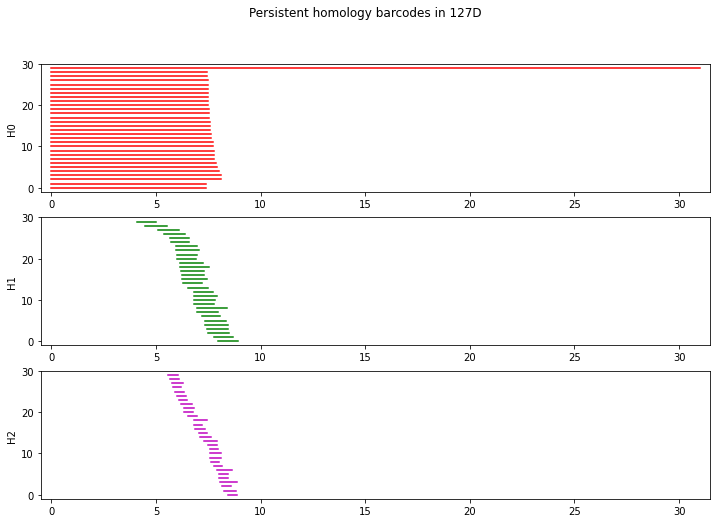

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


with open('barcodes.pickle', 'rb') as file:
		results = pickle.load(file)

col_list = ['r', 'g', 'm', 'c']
h0, h1, h2 = results['h0'], results['h1'], results['h2']
# replace the infinity bar (-1) in H0 by a really large number
h0[~np.isfinite(h0)] = max_dist
# Plot the 30 longest barcodes only
to_plot = []
for curr_h in [h0, h1, h2]:
     bar_lens = curr_h[:,1] - curr_h[:,0]
     plot_h = curr_h[(-bar_lens).argsort()[:30]]
     to_plot.append(plot_h[np.argsort(plot_h[:,0]),:])
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 4)
for curr_betti, curr_bar in enumerate(to_plot):
	ax = fig.add_subplot(gs[curr_betti, :])
	for i, interval in enumerate(reversed(curr_bar)):
		ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti],
            lw=1.5)
	ax.set_ylabel('H' + str(curr_betti))
	ax.set_xlim([-0.5, np.max(np.vstack((h0,h1,h2)))+0.5])
	# ax.set_xticks([0, xlim])
	ax.set_ylim([-1, len(curr_bar)])
	# ax.set_yticks([])
fig.suptitle('Persistent homology barcodes in 127D')

## **Intrinsic dimension**

Results above suggest that the topology of SWR waveforms follows a continuum with no holes nor cavities in the 127D space. We next compute the intrinsic dimension of the data using an estimator called ABID [[Thordsen, E. and Schubert, E (2022)](10.1109/TPAMI.2014.2343220)]



In [ ]:
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm


def abids(X,k):
    search_struct = cKDTree(X)
    return np.array([
        abid(X,k,x,search_struct)
        for x in tqdm(X,desc="abids",leave=False)
    ])


def abid(X,k,x,search_struct,offset=1):
    neighbor_norms, neighbors = search_struct.query(x,k+offset)
    neighbors = X[neighbors[offset:]] - x
    normed_neighbors = neighbors / neighbor_norms[offset:,None]
    # Original publication version that computes all cosines
    # coss = normed_neighbors.dot(normed_neighbors.T)
    # return np.mean(np.square(coss))**-1
    # Using another product to get the same values with less effort
    para_coss = normed_neighbors.T.dot(normed_neighbors)
    return k**2 / np.sum(np.square(para_coss))


ID = np.round(np.nanmean(abids(ripple_data['ripples'], 50)))
print('Intrinsic dimension = %d'%int(ID))

4.0


## **Dimensionality reduction**

After knowing the intrinsic dimension of SWR data (4D), we now look to map the representation into the low-dimensional space. To this end we apply UMAP [[McInnes, L., Healy, J. and Melville, J. (2018)](	arXiv:1802.03426)] as a dimensionality reduction technique.

In [ ]:
import umap


n_val = 15
d_val = 0.1
D = int(ID)
metric = 'euclidean'
metric_kwds=None

embedding = umap.UMAP(n_neighbors=n_val,
                      min_dist=d_val,
                      n_components=D,
                      metric=metric,
                      metric_kwds=metric_kwds)
embedding.fit(ripple_data['ripples'])
emb = embedding.embedding_

How do SWR features (e.g. frequency, amplitude and entropy) distribute in the reduced embedding? Since the intrinsic dimension is 4, we can visualize the 2D projections of the embedding. We show in this case the embedding projected over UMAP1 and UMAP2.

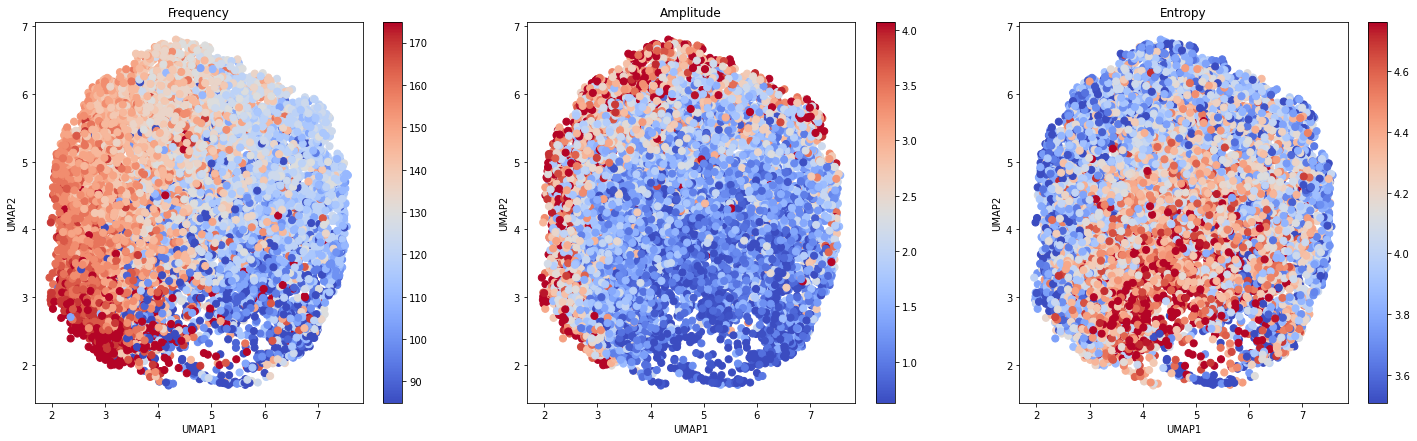

In [ ]:
f, ax = plt.subplots(1,3, figsize=(25,7))
s = ax[0].scatter(emb[:,0], emb[:,1], c=ripple_data['freq'], vmin=np.percentile(ripple_data['freq'],5), vmax=np.percentile(ripple_data['freq'],95), cmap='coolwarm', s=50)
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Frequency')
f.colorbar(s, ax=ax[0])

s = ax[1].scatter(emb[:,0], emb[:,1], c=ripple_data['amp'], vmin=np.percentile(ripple_data['amp'],5), vmax=np.percentile(ripple_data['amp'],95), cmap='coolwarm', s=50)
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('Amplitude')
f.colorbar(s, ax=ax[1])

s = ax[2].scatter(emb[:,0], emb[:,1], c=ripple_data['entropy'], vmin=np.percentile(ripple_data['entropy'],5), vmax=np.percentile(ripple_data['entropy'],95), cmap='coolwarm', s=50)
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
ax[2].set_title('Entropy')
f.colorbar(s, ax=ax[2])

As can be seen, the three features show structure when projected over the point cloud. The next questions that arise are:

1.   Can we quantify this structure?

2.   Was this structure present in the original space before dimensionality reduction?

To answer them we apply the method we developed to this end, the [Structure Index (SI)](https://doi.org/10.1101/2022.11.23.517657)

## **Structure Index**

The Structure Index is a topological metric developed to quantify the structure of a label projected over an embedding in an arbitrary dimension. To use it we need to follow the steps below:

Go to project folder and clone Structure Index repository.

In [ ]:
%cd /content
! git clone https://github.com/PridaLab/structure_index.git

/content
Cloning into 'structure_index'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 127 (delta 71), reused 73 (delta 31), pack-reused 0
Receiving objects: 100% (127/127), 59.27 KiB | 2.96 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [ ]:
import sys
sys.path.insert(0, '/content/structure_index')
#from structure_index import *
from structure_index import compute_structure_index

Define the variables needed to compute Structure Index

In [ ]:
varList =  ['freq', 'amp', 'entropy']
labelList = [ripple_data['freq'],
			       ripple_data['amp'],
			       ripple_data['entropy']]
valLimits = [(70,190),
             (np.percentile(labelList[1], 5), np.percentile(labelList[1], 95)),
			       (np.percentile(labelList[2], 5), np.percentile(labelList[2], 95))]

params = {
'graph_type': 'weighted',
'overlap_method': 'continuity',
'dicrete_bin_label': False,
'verbose': True,
'num_shuffles': 10,
'n_bins': 10,
}

sI_labels_original = np.empty(len(varList))
sI_shuffle_original = np.empty((params['num_shuffles'],len(varList)))
for v in range(len(varList)):
	print('Computing for variable %s' % varList[v])
	#Compute for freq label
	label = labelList[v]
	params['min_label'], params['max_label'] = valLimits[v]
	sI_labels_original[v], _, _,sI_shuffle_original[:,v] = compute_structure_index(ripple_data['ripples'], label, n_neighbors = 3, **params)

sI_labels_reduced = np.empty(len(varList))
sI_shuffle_reduced = np.empty((params['num_shuffles'],len(varList)))
for v in range(len(varList)):
	print('Computing for variable %s' % varList[v])
	#Compute for freq label
	label = labelList[v]
	params['min_label'], params['max_label'] = valLimits[v]
	sI_labels_reduced[v], _, _,sI_shuffle_reduced[:,v] = compute_structure_index(emb, label, n_neighbors = 3, **params)

Computing for variable freq
Computing bin-groups...: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index...: 0.64


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.01
Computing for variable amp
Computing bin-groups...: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index...: 0.53


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.01
Computing for variable entropy
Computing bin-groups...: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index...: 0.33


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.01
Computing for variable freq
Computing bin-groups...: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index...: 0.59


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.01
Computing for variable amp
Computing bin-groups...: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index...: 0.46


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.01
Computing for variable entropy
Computing bin-groups...: Done


Computing overlap:   0%|          | 0/45 [00:00<?, ?it/s]

Computing structure index...: 0.30


Computing shuffling:   0%|          | 0/10 [00:00<?, ?it/s]

Shuffling 99th percentile: 0.01


We now plot the values of SI per feature as estimated in the original and the reduced embedding.

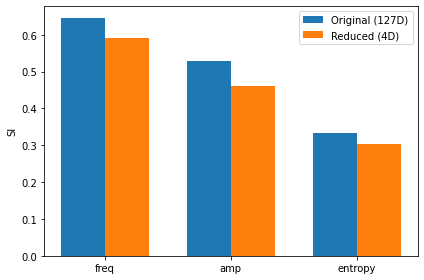

In [ ]:
x = np.arange(len(varList))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, sI_labels_original, width, label='Original (127D)')
rects2 = ax.bar(x + width/2, sI_labels_reduced, width, label='Reduced (4D)')

ax.set_ylabel('SI')
ax.set_xticks(x)
ax.set_xticklabels(varList)
ax.legend()

fig.tight_layout()

plt.show()

As we can see, there is structure both in the reduced embedding and in the original high-dimensional space, confirming visualization trends.